In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
from sklearn.covariance import LedoitWolf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
import pymongo
from pathlib import Path
import mlflow
import mlflow.sklearn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from functools import partial
import logging
import time
import itertools
from tqdm import tqdm

In [2]:
STOCK_SYMBOLS = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'BAC', 'V']
DAYS = 300
load_dotenv()

def fetch_stock_data():
    """Fetch historical stock data and save it using DVC."""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=DAYS)
    
    all_data = pd.DataFrame()
    
    for symbol in STOCK_SYMBOLS:
        try:
            data = yf.download(symbol, start=start_date, end=end_date)
            print('-----------------'*14)
            if not data.empty:
                # Calculate daily returns
                data['Returns'] = data['Close'].pct_change()
                # Add symbol column
                data['Symbol'] = symbol
                # Append to main dataframe
                all_data = pd.concat([all_data, data])
                print(data.head(5))
            else:
                print(f"No data found for {symbol}")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
    
    # Save data
    all_data.to_csv('data/stock_data.csv')
    return all_data

def prepare_training_data(all_data):
    """Prepare data for training the portfolio optimization model."""
    # Reshape data for returns calculation
    returns_data = all_data.reset_index().pivot(index='Date', columns='Symbol', values='Returns')
    returns_data = returns_data.dropna()
    
    return returns_data

In [3]:
all_data = fetch_stock_data()
fin = prepare_training_data(all_data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL   
Date                                                                   
2024-07-03  220.807892  220.807892  218.296329  219.263081  37369800   
2024-07-05  225.581833  225.691465  220.907540  220.907540  60412400   
2024-07-08  227.056885  227.086783  222.502185  226.329319  59085900   
2024-07-09  227.913986  228.631576  225.611726  227.166498  48076100   
2024-07-10  232.199585  232.299256  228.482084  228.531919  62627700   

Price        Returns Symbol  
Ticker                       
Date                         
2024-07-03       NaN   AAPL  
2024-07-05  0.021620   AAPL  
2024-07-08  0.006539   AAPL  
2024

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open    Volume  \
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT   
Date                                                                   
2024-07-03  458.103638  458.352191  455.230377  455.538581   9932800   
2024-07-05  464.854340  465.639777  456.314052  456.950332  16000300   
2024-07-08  463.541992  464.993565  461.772294  463.850196  12962300   
2024-07-09  456.880768  464.625667  455.349671  464.297590  17207200   
2024-07-10  463.551941  463.760717  456.204690  458.551049  18196100   

Price        Returns Symbol  
Ticker                       
Date                         
2024-07-03       NaN   MSFT  
2024-07-05  0.014736   MSFT  
2024-07-08 -0.002823   MSFT  
2024

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open    Volume  \
Ticker            GOOG        GOOG        GOOG        GOOG      GOOG   
Date                                                                   
2024-07-03  186.718857  186.948029  184.721033  185.632764   7409100   
2024-07-05  191.272491  191.571405  186.649110  186.649110  14303400   
2024-07-08  189.797775  190.992486  188.641941  190.679615  12097600   
2024-07-09  189.757935  192.169265  189.548680  191.063240  10198500   
2024-07-10  191.969986  192.617652  189.937284  190.066823  12052900   

Price        Returns Symbol  
Ticker                       
Date                         
2024-07-03       NaN   GOOG  
2024-07-05  0.024388   GOOG  
2024-07-08 -0.007710   GOOG  
2024

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open    Volume  \
Ticker            AMZN        AMZN        AMZN        AMZN      AMZN   
Date                                                                   
2024-07-03  197.589996  200.029999  196.759995  199.940002  31597900   
2024-07-05  200.000000  200.550003  198.169998  198.649994  39858900   
2024-07-08  199.289993  201.199997  197.960007  200.039993  34767300   
2024-07-09  199.339996  200.570007  199.050003  199.399994  32700100   
2024-07-10  199.789993  200.110001  197.690002  200.000000  32883800   

Price        Returns Symbol  
Ticker                       
Date                         
2024-07-03       NaN   AMZN  
2024-07-05  0.012197   AMZN  
2024-07-08 -0.003550   AMZN  
2024

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open    Volume  \
Ticker            META        META        META        META      META   
Date                                                                   
2024-07-03  508.610840  509.927355  504.681261  505.030341   6005600   
2024-07-05  538.481506  539.438988  510.246440  510.246440  21354100   
2024-07-08  527.919617  541.373917  525.256698  540.915112  14917500   
2024-07-09  528.597839  536.058031  526.792630  532.337918   8753200   
2024-07-10  533.275391  537.454308  526.962121  529.385684  10983300   

Price        Returns Symbol  
Ticker                       
Date                         
2024-07-03       NaN   META  
2024-07-05  0.058730   META  
2024-07-08 -0.019614   META  
2024

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open     Volume  \
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA   
Date                                                                    
2024-07-03  246.389999  248.350006  234.250000  234.559998  166561500   
2024-07-05  251.520004  252.369995  242.460007  249.809998  154501200   
2024-07-08  252.940002  259.440002  244.570007  247.710007  157219600   
2024-07-09  262.329987  265.609985  250.300003  251.000000  160210900   
2024-07-10  263.260010  267.589996  257.859985  262.799988  128519400   

Price        Returns Symbol  
Ticker                       
Date                         
2024-07-03       NaN   TSLA  
2024-07-05  0.020821   TSLA  
2024-07-08  0.005646   TSL

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open     Volume  \
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA   
Date                                                                    
2024-07-03  128.248398  128.248398  121.330104  121.630034  215749000   
2024-07-05  125.799004  128.818264  125.649039  127.348617  214176700   
2024-07-08  128.168396  130.737770  127.008686  127.458572  237677300   
2024-07-09  131.347641  133.787042  128.618303  130.317896  285366600   
2024-07-10  134.876770  135.066726  132.387378  133.996982  248978600   

Price        Returns Symbol  
Ticker                       
Date                         
2024-07-03       NaN   NVDA  
2024-07-05 -0.019099   NVDA  
2024-07-08  0.018835   NVD

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open   Volume   Returns  \
Ticker             JPM         JPM         JPM         JPM      JPM             
Date                                                                            
2024-07-03  203.959778  205.611474  202.943342  204.800285  5560900       NaN   
2024-07-05  201.257202  203.792697  200.991871  203.419262  8093100 -0.013251   
2024-07-08  201.630661  203.330813  200.451365  201.502899  8707000  0.001856   
2024-07-09  204.048218  206.141463  201.905817  202.082719  9058900  0.011990   
2024-07-10  204.215302  204.382367  202.033597  202.583934  8328500  0.000819   

Price      Symbol  
Ticker             
Date               
2024-07-03    JPM  
2024-07-05    JPM  
2024-07-08  

[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price           Close       High        Low       Open    Volume   Returns  \
Ticker            BAC        BAC        BAC        BAC       BAC             
Date                                                                         
2024-07-03  40.156872  40.451420  40.009596  40.274690  17100700       NaN   
2024-07-05  39.675770  40.215776  39.557951  40.186322  23489000 -0.011981   
2024-07-08  39.881958  40.294329  39.695412  39.862321  26728500  0.005197   
2024-07-09  40.667423  41.069977  39.862322  40.019415  34697200  0.019695   
2024-07-10  40.981609  41.001243  40.323781  40.529964  25333400  0.007726   

Price      Symbol  
Ticker             
Date               
2024-07-03    BAC  
2024-07-05    BAC  
2024-07-08    BAC  
2024-07-09    BA

[*********************100%***********************]  1 of 1 completed

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Price            Close        High         Low        Open   Volume   Returns  \
Ticker               V           V           V           V        V             
Date                                                                            
2024-07-03  267.492157  268.247935  266.656838  267.571729  5017800       NaN   
2024-07-05  268.854523  269.043467  266.746332  267.502110  7986400  0.005093   
2024-07-08  264.916565  269.928509  264.488967  268.745133  8561100 -0.014647   
2024-07-09  263.961945  266.060181  262.450419  265.513256  6431300 -0.003603   
2024-07-10  261.535553  262.012891  257.070564  257.677153  9635500 -0.009192   

Price      Symbol  
Ticker             
Date               
2024-07-03      V  
2024-07-05      V  
2024-07-08  

In [4]:
def objective(params, returns_data):
    """MLflow/Hyperopt objective function for optimizing portfolio weights."""
    # Extract weights from params
    weights = np.array([params[f"w_{i}"] for i in range(len(STOCK_SYMBOLS))])
    weights = weights / np.sum(weights)  # Normalize to sum to 1
    
    # Calculate portfolio performance
    portfolio_return = np.sum(returns_data.mean() * weights) * 252  # Annualized return
    
    # Use Ledoit-Wolf covariance estimator (robust to estimation error)
    cov_estimator = LedoitWolf().fit(returns_data)
    cov_matrix = cov_estimator.covariance_
    
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    
    # Sharpe ratio (assuming risk-free rate = 0 for simplicity)
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    # Log parameters and metrics with MLflow
    for i, symbol in enumerate(STOCK_SYMBOLS):
        mlflow.log_param(f"weight_{symbol}", weights[i])
    
    mlflow.log_metric("sharpe_ratio", sharpe_ratio)
    mlflow.log_metric("portfolio_return", portfolio_return)
    mlflow.log_metric("portfolio_volatility", portfolio_volatility)
    
    # Return negative sharpe ratio for minimization
    return {'loss': -sharpe_ratio, 'status': STATUS_OK}

def evaluate_portfolio(weights, returns_data):
    """Evaluate portfolio performance for a set of weights."""
    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)
    
    # Calculate portfolio performance
    portfolio_return = np.sum(returns_data.mean() * weights) * 252  # Annualized return
    
    # Use Ledoit-Wolf covariance estimator (robust to estimation error)
    cov_estimator = LedoitWolf().fit(returns_data)
    cov_matrix = cov_estimator.covariance_
    
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    
    # Sharpe ratio (assuming risk-free rate = 0 for simplicity)
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    return {
        'weights': weights,
        'portfolio_return': portfolio_return,
        'portfolio_volatility': portfolio_volatility,
        'sharpe_ratio': sharpe_ratio
    }

Evaluating 2357 portfolio configurations...


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


trying to save model to mongodb
mongodb://localhost:27017/
Model saved to MongoDB


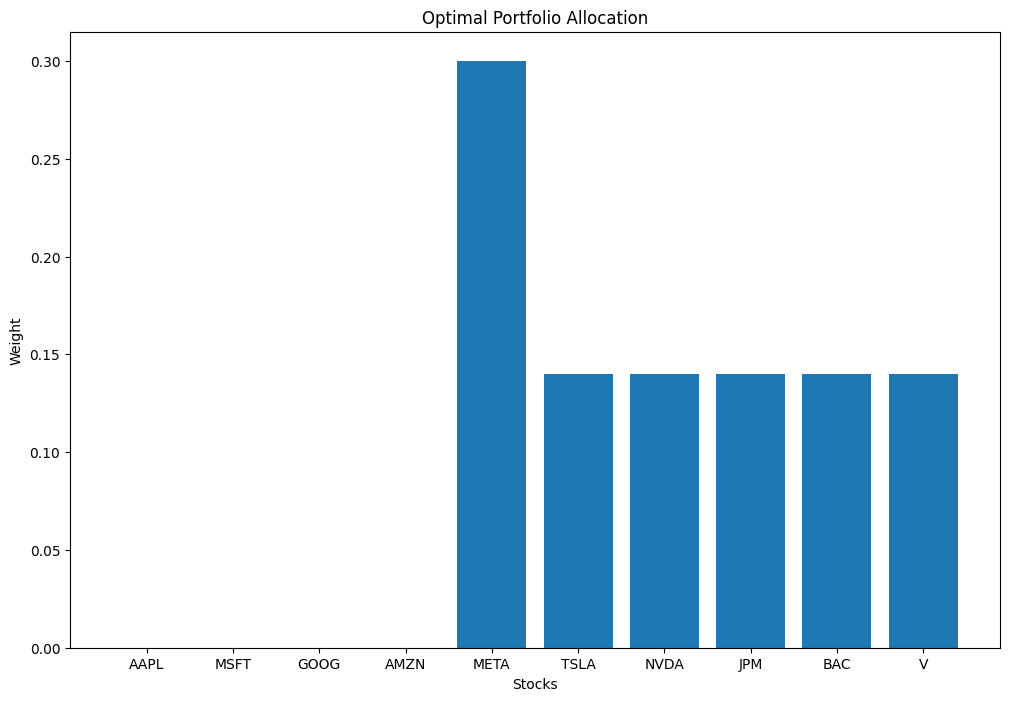

In [5]:
returns_data = prepare_training_data(all_data)

# Save prepared data for DVC tracking
returns_data.to_csv('data/returns_data.csv')

# Set up MLflow tracking
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("portfolio_optimization")

with mlflow.start_run(run_name=f"grid_search_optimization_{time.strftime('%Y-%m-%d_%H:%M:%S')}"):
    # Define a grid of weight allocations
    # We'll use a coarse grid to keep computation manageable
    # Each stock can have weights of 0.0, 0.2, 0.4, 0.6, 0.8, or 1.0
    # but we'll filter to only keep combinations where weights sum approximately to 1
    
    # For a 10-stock portfolio, a full grid would be too large
    # Let's start with fixed steps and filter combinations
    weights_grid = []
    
    # Define possible weight values for each stock
    weight_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    
    # Generate initial weight combinations for first 5 stocks
    # We'll set constraints for the remaining stocks based on these
    for combo in itertools.product(weight_values, repeat=5):
        # If the sum is already > 1, skip this combination
        if sum(combo) > 1.0:
            continue
            
        # Calculate remaining weight for other stocks
        remaining_weight = 1.0 - sum(combo)
        
        # Set a simple allocation for the remaining stocks
        # Distribute the remaining weight equally among the other stocks
        remaining_per_stock = remaining_weight / 5
        
        # Create the full weight vector
        weights = list(combo) + [remaining_per_stock] * 5
        
        # Add to our grid
        weights_grid.append(weights)
    
    # Add more specific weight combinations
    # Equal weights
    weights_grid.append([0.1] * 10)
    
    # Tech-heavy portfolio
    tech_weights = [0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0]
    weights_grid.append(tech_weights)
    
    # Finance-heavy portfolio
    finance_weights = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.3, 0.3]
    weights_grid.append(finance_weights)
    
    # Mixed portfolio
    mixed_weights = [0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05]
    weights_grid.append(mixed_weights)
    
    print(f"Evaluating {len(weights_grid)} portfolio configurations...")
    
    # Evaluate each combination
    best_sharpe_ratio = -float('inf')
    best_portfolio = None
    
    for weights in tqdm(weights_grid[:4]):
        weights = np.array(weights)
        
        # Evaluate portfolio
        portfolio = evaluate_portfolio(weights, returns_data)
        # Log to MLflow
        with mlflow.start_run(run_name="portfolio_config", nested=True):
            # Log parameters (weights)
            for i, symbol in enumerate(STOCK_SYMBOLS):
                mlflow.log_param(f"weight_{symbol}", portfolio['weights'][i])
            
            # Log metrics
            mlflow.log_metric("sharpe_ratio", portfolio['sharpe_ratio'])
            mlflow.log_metric("portfolio_return", portfolio['portfolio_return'])
            mlflow.log_metric("portfolio_volatility", portfolio['portfolio_volatility'])
        
        # Track best portfolio
        if portfolio['sharpe_ratio'] > best_sharpe_ratio:
            best_sharpe_ratio = portfolio['sharpe_ratio']
            best_portfolio = portfolio
    
    # Extract the best weights
    best_weights = best_portfolio['weights']
    
    # Create model dictionary
    model = {
        'weights': best_weights.tolist(),
        'symbols': STOCK_SYMBOLS,
        'training_date': datetime.now().strftime('%Y-%m-%d'),
        'metrics': {
            'sharpe_ratio': best_sharpe_ratio,
            'portfolio_return': best_portfolio['portfolio_return'],
            'portfolio_volatility': best_portfolio['portfolio_volatility']
        }
    }
    
    # Save model with MLflow
    mlflow.log_dict(model, "model/portfolio_model.json")
    
    # Save model locally for compatibility with existing code
    joblib.dump(model, 'models/portfolio_model.joblib')
    
    # Save metrics for DVC tracking
    with open('results/metrics.json', 'w') as f:
        json.dump({
            'sharpe_ratio': float(best_sharpe_ratio),
            'portfolio_return': float(best_portfolio['portfolio_return']),
            'portfolio_volatility': float(best_portfolio['portfolio_volatility']),
            'training_date': datetime.now().strftime('%Y-%m-%d')
        }, f)
    
    # Create visualization of optimal portfolio allocation
    plt.figure(figsize=(12, 8))
    plt.bar(STOCK_SYMBOLS, best_weights)
    plt.xlabel('Stocks')
    plt.ylabel('Weight')
    plt.title('Optimal Portfolio Allocation')
    plt.savefig('results/portfolio_allocation.png')

    # Log figure with MLflow
    mlflow.log_artifact('results/portfolio_allocation.png')
    
    # Store model in MongoDB if connection details are provided
    print('trying to save model to mongodb')
    mongo_uri = os.getenv('MONGO_URI')
    print(mongo_uri)
    if mongo_uri:
        try:
            client = pymongo.MongoClient(mongo_uri)
            db = client.portfolio_optimization
            collection = db.models
            
            # Convert numpy arrays to lists for MongoDB
            model_doc = {
                'weights': best_weights.tolist(),
                'symbols': STOCK_SYMBOLS,
                'training_date': datetime.now(),
                'sharpe_ratio': float(best_sharpe_ratio),
                'portfolio_return': float(best_portfolio['portfolio_return']),
                'portfolio_volatility': float(best_portfolio['portfolio_volatility']),
                'mlflow_run_id': mlflow.active_run().info.run_id
            }
            
            collection.insert_one(model_doc)
            print("Model saved to MongoDB")
        except Exception as e:
            print(f"Error saving to MongoDB: {e}")

In [7]:
returns_data

Symbol,AAPL,AMZN,BAC,GOOG,JPM,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2024-07-05,0.021620,0.012197,-0.011981,0.024388,-0.013251,0.058730,0.014736,-0.019099,0.020821,0.005093
2024-07-08,0.006539,-0.003550,0.005197,-0.007710,0.001856,-0.019614,-0.002823,0.018835,0.005646,-0.014647
2024-07-09,0.003775,0.000251,0.019695,-0.000210,0.011990,0.001285,-0.014370,0.024805,0.037123,-0.003603
2024-07-10,0.018804,0.002257,0.007726,0.011657,0.000819,0.008849,0.014602,0.026869,0.003545,-0.009192
2024-07-11,-0.023221,-0.023725,0.001677,-0.027821,-0.001684,-0.041127,-0.024772,-0.055667,-0.084441,-0.001711
...,...,...,...,...,...,...,...,...,...,...
2025-04-22,0.034065,0.035023,0.037920,0.026958,0.028822,0.032229,0.021441,0.020431,0.046022,0.035301
2025-04-23,0.024332,0.042846,0.011221,0.024821,0.022454,0.039958,0.020637,0.038629,0.053662,0.008962
2025-04-24,0.018426,0.032890,0.021419,0.023776,0.015609,0.024756,0.034483,0.036218,0.034976,0.004008
